In [1]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import scipy.stats as stats
from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')

# Generate Paths

In [2]:
file_path = '/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_historical_D1/gfdl.ncrc4-intel16-prod-openmp/pp'
diagType1 = 'ocean_cobalt_omip_tracers_year_z'
diagType2 = 'ocean_cobalt_omip_tracers_month_z'

years = ['1995-1999', '2000-2004', '2005-2009', '2010-2014']
yearmons = ['199501-199912', '200001-200412', '200501-200912', '201001-201412']

In [3]:
# using python's list comprehension and path/string join method to put together the appropriate paths
dot = '.'
no3_var = 'no3'
no3_file_prefix = os.path.join(file_path, diagType1, 'ts', 'annual', '5yr/')
no3_files = [dot.join([no3_file_prefix + diagType1, yy, no3_var, 'nc']) for yy in years]
# print(no3_files)

po4_var = 'po4'
po4_file_prefix = os.path.join(file_path, diagType1, 'ts', 'annual', '5yr/')
po4_files = [dot.join([po4_file_prefix + diagType1, yy, po4_var, 'nc']) for yy in years]
# print(po4_files)

si_var = 'si'
si_file_prefix = os.path.join(file_path, diagType1, 'ts', 'annual', '5yr/')
si_files = [dot.join([si_file_prefix + diagType1, yy, si_var, 'nc']) for yy in years]
# print(si_files)

dfe_var = 'dfe'
dfe_file_prefix = os.path.join(file_path, diagType2, 'ts', 'monthly', '5yr/')
dfe_files = [dot.join([dfe_file_prefix + diagType2, ym, dfe_var, 'nc']) for ym in yearmons]
# print(dfe_files)

In [4]:
grid_file = '/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_historical_D1/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual/ocean_annual.static.nc'
grid = xr.open_dataset(grid_file)

# Read in Data

### Models

In [5]:
# Get surface values only; make 20-yr mean out of annual data

#no3
ds_no3 = xr.open_mfdataset(no3_files, combine='by_coords')
ds_no3 = ds_no3.isel(z_l=0).mean(dim='time')
ds_no3['no3'].values = ds_no3['no3'].values * 1e3 # unit conversion to mmol m-3
ds_no3.no3.attrs['units'] = 'mmol m-3'

#po4
ds_po4 = xr.open_mfdataset(po4_files, combine='by_coords')
ds_po4 = ds_po4.isel(z_l=0).mean(dim='time')
ds_po4['po4'].values = ds_po4['po4'].values * 1e3 # unit conversion to mmol m-3
ds_po4.po4.attrs['units'] = 'mmol m-3'

#si
ds_si = xr.open_mfdataset(si_files, combine='by_coords')
ds_si = ds_si.isel(z_l=0).mean(dim='time')
ds_si['si'].values = ds_si['si'].values * 1e3 # unit conversion to mmol m-3
ds_si.si.attrs['units'] = 'mmol m-3'

In [6]:
#dfe, use monthly data because sampling in observations is highly skewed toward spr/summer/fall
ds_dfe = xr.open_mfdataset(dfe_files, combine='by_coords')
ds_dfe = ds_dfe.isel(z_l=0)

# unit conversion to micromol m-3
ds_dfe['dfe'].values = ds_dfe['dfe'].values * 1e6
ds_dfe.dfe.attrs['units'] = 'micromol m-3'

#create climatology
ds_dfe_clim=ds_dfe.groupby('time.month').mean(dim='time')

### Observations

In [7]:
# Nitrate
no3_obs_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/nitrate_woa18_esm4grid.nc'
no3_obs = xr.open_dataset(no3_obs_file)
no3_obs = no3_obs.isel(z_l=0)

# Phosphate
po4_obs_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/phosphate_woa18_esm4grid.nc'
po4_obs = xr.open_dataset(po4_obs_file)
po4_obs = po4_obs.isel(z_l=0)

# Silicate
si_obs_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/silicate_woa18_esm4grid.nc'
si_obs = xr.open_dataset(si_obs_file)
si_obs = si_obs.isel(z_l=0)

# Iron
dfe_obs_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/fed_obs_sfc.nc'
dfe_obs = xr.open_dataset(dfe_obs_file)
dfe_obs_ann = dfe_obs.mean(dim='time')

In [8]:
ds_dfe_4_9_avg = ds_dfe_clim.sel(month=slice(4,9)).mean(dim='month')
ds_dfe_10_3_avg = ds_dfe_clim.sel(month=[1,2,3,10,11,12]).mean(dim='month')
# dfe_mod_ann = squeeze(mean(dfe_mod_mc,1));
# dfe_mod_ann2 = dfe_mod_ann;
# dfe_mod_4_9_avg = squeeze(mean(dfe_mod_mc([4 5 6 7 8 9],:,:),1));
# dfe_mod_10_3_avg = squeeze(mean(dfe_mod_mc([1 2 3 10 11 12],:,:),1));
# dfe_mod_ann2(lat_mod > 35) = dfe_mod_4_9_avg(lat_mod > 35);
# dfe_mod_ann2(lat_mod < -35) = dfe_mod_10_3_avg(lat_mod < -35);

In [9]:
no3_obs.nitrate_woa18.shape

(576, 720)

# Evaluate Skill Metrics

In [10]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def rmse_diffs(differences):
    return np.sqrt(np.sum((differences ** 2)/len(differences)))

In [11]:
def log_differences(ds1, ds2, minimum=0.1):
    if(len(ds1) != len(ds2)):
        print('ERROR: Arrays are not the same length')
        return NULL
    array_length=len(ds1)
    min_array = np.repeat(minimum,array_length)
    
    log_ds1 = np.log10(np.maximum(ds1, min_array))
    log_ds2 = np.log10(np.maximum(ds2, min_array))
    
    return log_ds1 - log_ds2

In [12]:
# Annual means, Nitrate
X=ds_no3.no3.stack(z=('xh','yh')).values
Y=no3_obs.nitrate_woa18.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_no3 = X[mask] - Y[mask]
res2_no3 = log_differences(X[mask],Y[mask],minimum=0.1)
skew1_no3 = stats.skew(res1_no3)
skew2_no3 = stats.skew(res2_no3)
res_no3 = res1_no3
r_no3 = stats.pearsonr(X[mask],Y[mask])[0]
rmse_no3 = rmse_diffs(res_no3)
bias_no3 = np.mean(res_no3)

In [13]:
# Annual means, Phosphate
X=ds_po4.po4.stack(z=('xh','yh')).values
Y=po4_obs.phosphate_woa18.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_po4 = X[mask] - Y[mask]
res2_po4 = log_differences(X[mask],Y[mask],minimum=0.01)
skew1_po4 = stats.skew(res1_po4)
skew2_po4 = stats.skew(res2_po4)
res_po4 = res1_po4
r_po4 = stats.pearsonr(X[mask],Y[mask])[0]
rmse_po4 = rmse_diffs(res_po4)
bias_po4 = np.mean(res_po4)

In [14]:
# Annual means, Silicate
X=ds_si.si.stack(z=('xh','yh')).values
Y=si_obs.silicate_woa18.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_si = X[mask] - Y[mask]
res2_si = log_differences(X[mask],Y[mask],minimum=0.01)
skew1_si = stats.skew(res1_si)
skew2_si = stats.skew(res2_si)
res_si = res1_si
r_si = stats.pearsonr(X[mask],Y[mask])[0]
rmse_si = rmse_diffs(res_si)
bias_si = np.mean(res_si)

In [15]:
# Monthly climatology, Iron
X=ds_dfe_clim.dfe.stack(z=('month','xh','yh')).values
Y=dfe_obs.fed_obs_sfc.stack(z=('time','xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y),Y>0)

ma_len = len(X[mask])
res1_dfe = X[mask] - Y[mask]
res2_dfe = log_differences(X[mask],Y[mask],minimum=0.1)
skew1_dfe = stats.skew(res1_dfe)
skew2_dfe = stats.skew(res2_dfe)
res_dfe = res1_dfe
r_dfe = stats.pearsonr(X[mask],Y[mask])[0]
rmse_dfe = rmse_diffs(res_dfe)
bias_dfe = np.mean(res_dfe)

# Plot

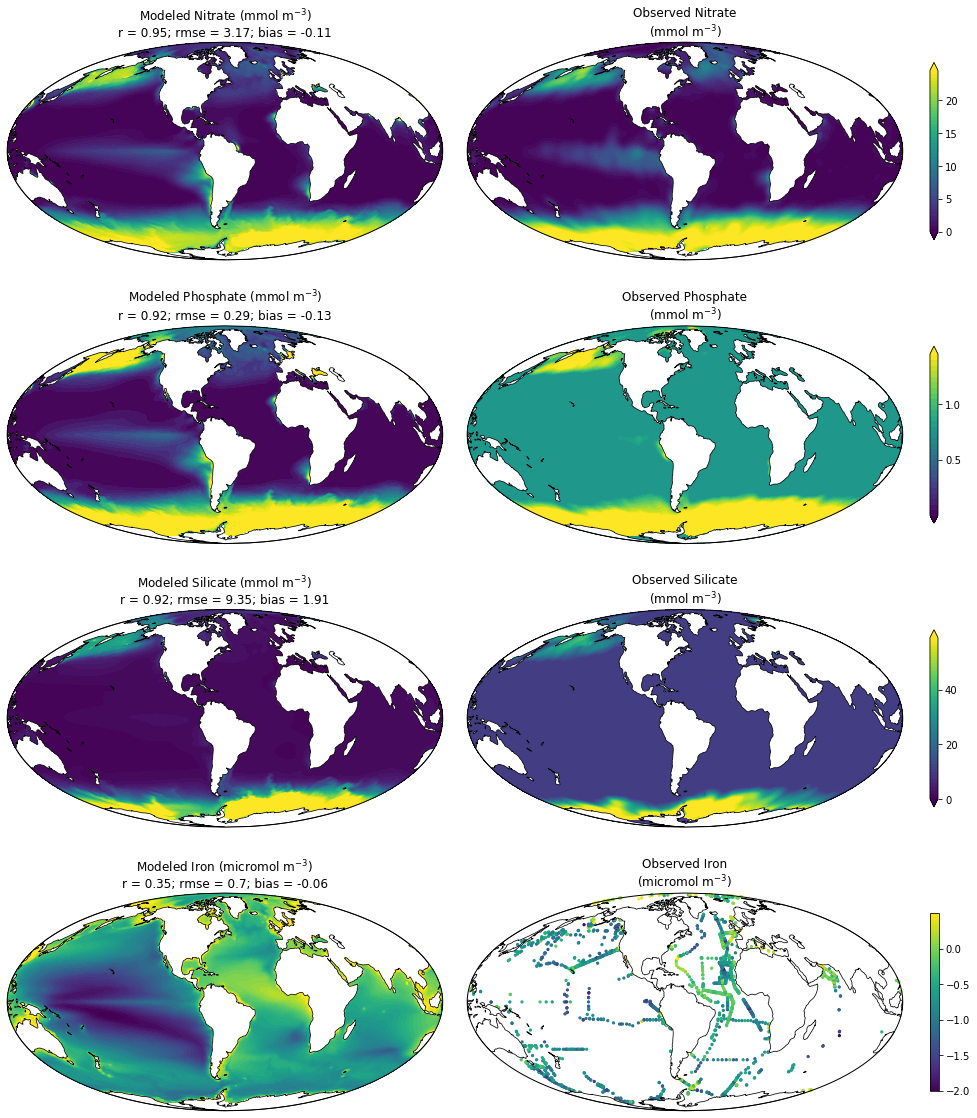

In [16]:
fig=plt.figure(figsize=(18,20))
gs=gridspec.GridSpec(4,2, wspace=0.05, width_ratios=[1,1.25])

ax={};cs={}

fs = 12 #fontsize

###########################################################################
# no3                                                                     #
###########################################################################
cmin=0; cmax=25; cint=.5
levels=np.arange(cmin,cmax,cint)

i=0
ax[i]=plt.subplot(gs[0,0],projection=ccrs.Mollweide(central_longitude=300.0))
field=ds_no3.no3
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Modeled Nitrate (mmol m$^{-3}$)\nr = ' + str(np.round(r_no3,2)) + \
                 '; rmse = ' + str(np.round(rmse_no3,2)) + \
                 '; bias = ' + str(np.round(bias_no3,2)), fontsize=fs)

i=1
ax[i]=plt.subplot(gs[0,1],projection=ccrs.Mollweide(central_longitude=300.0))
field=no3_obs.nitrate_woa18
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed Nitrate\n(mmol m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[0,5,10,15,20,25], shrink=0.75)

###########################################################################
# po4                                                                     #
###########################################################################
cmin = 0; cmax = 1.5; cint = 0.05
levels=np.arange(cmin,cmax,cint)

i=2
ax[i]=plt.subplot(gs[1,0],projection=ccrs.Mollweide(central_longitude=300.0))
field=ds_po4.po4
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Modeled Phosphate (mmol m$^{-3}$)\nr = ' + str(np.round(r_po4,2)) + \
                 '; rmse = ' + str(np.round(rmse_po4,2)) + \
                 '; bias = ' + str(np.round(bias_po4,2)), fontsize=fs)

i=3
ax[i]=plt.subplot(gs[1,1],projection=ccrs.Mollweide(central_longitude=300.0))
field=po4_obs.phosphate_woa18
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed Phosphate\n(mmol m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[0.5,1,1.5], shrink=0.75)

###########################################################################
# Silicate                                                                #
###########################################################################

cmin = 0; cmax = 60; cint = 1
levels=np.arange(cmin,cmax,cint)

i=4
ax[i]=plt.subplot(gs[2,0],projection=ccrs.Mollweide(central_longitude=300.0))
field=ds_si.si
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Modeled Silicate (mmol m$^{-3}$)\nr = ' + str(np.round(r_si,2)) + \
                 '; rmse = ' + str(np.round(rmse_si,2)) + \
                 '; bias = ' + str(np.round(bias_si,2)), fontsize=fs)

i=5
ax[i]=plt.subplot(gs[2,1],projection=ccrs.Mollweide(central_longitude=300.0))
field=si_obs.silicate_woa18
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed Silicate\n(mmol m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[0,20,40,60], shrink=0.75)

###########################################################################
# iron                                                                    #
###########################################################################

cmin = -2; cmax = 0.5; cint = 0.05
levels=np.arange(cmin,cmax,cint)

i=6
ax[i]=plt.subplot(gs[3,0],projection=ccrs.Mollweide(central_longitude=300.0))
field=np.log10(ds_dfe_clim.dfe.mean(dim='month').values)
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Modeled Iron (micromol m$^{-3}$)\nr = ' + str(np.round(r_dfe,2)) + \
                 '; rmse = ' + str(np.round(rmse_dfe,1)) + \
                 '; bias = ' + str(np.round(bias_dfe,2)), fontsize=fs)

i=7
ax[i]=plt.subplot(gs[3,1],projection=ccrs.Mollweide(central_longitude=300.0))
field=np.log10(dfe_obs.fed_obs_sfc.mean(dim='time').values)
cs[i]=ax[i].scatter(grid.geolon.values, grid.geolat.values, s=5, c=field, transform=ccrs.PlateCarree(), vmin=cmin, vmax=cmax)
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed Iron\n(micromol m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=np.arange(-2,0.5,0.5), shrink=0.75)
cbar.ax.set_xticklabels(['0.01','0.03','0.1','0.3','1']) 

plt.tight_layout()
fname = 'Mollweide_ESM4.1_sfc_nutrients'
plt.savefig('../plots/'+fname+'.png', dpi=300, bbox_inches='tight')

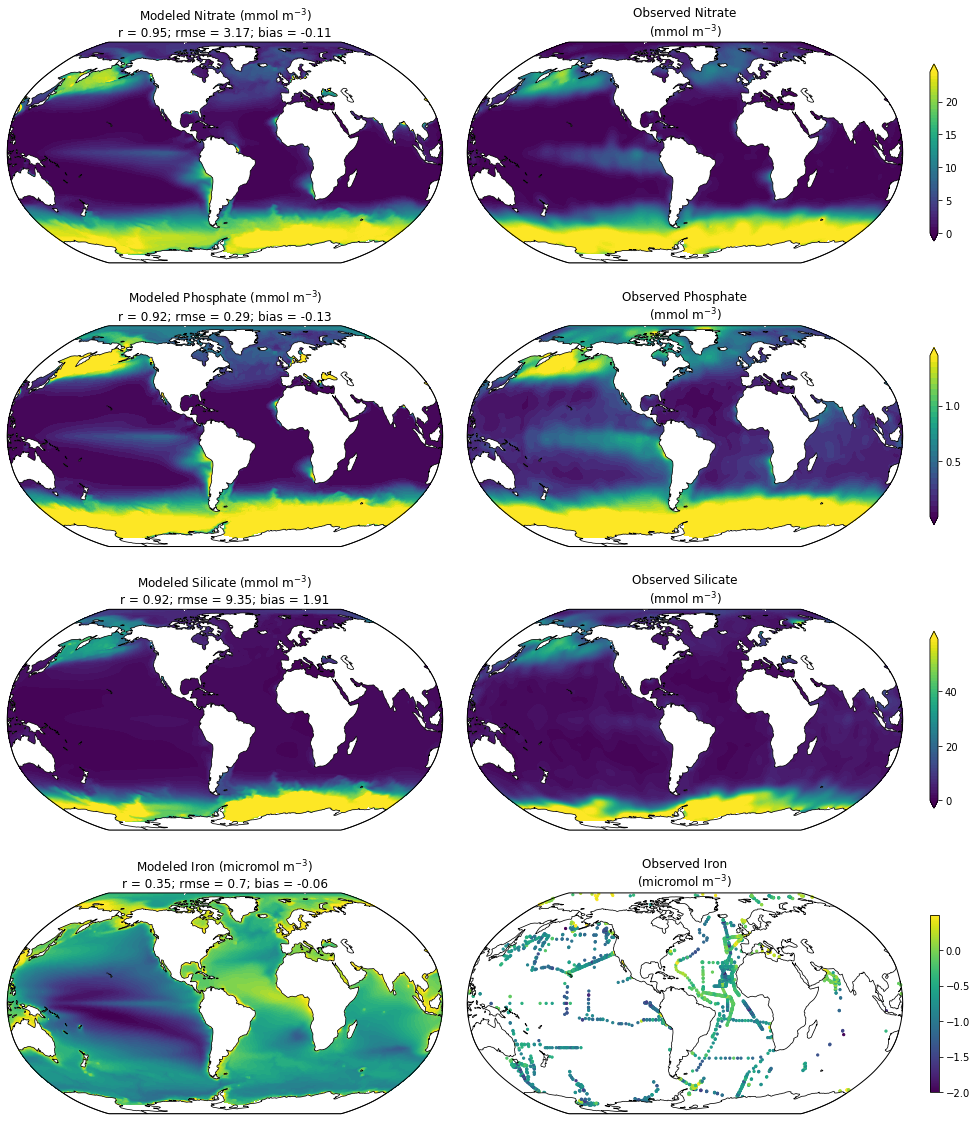

In [17]:
fig=plt.figure(figsize=(18,20))
gs=gridspec.GridSpec(4,2, wspace=0.05, width_ratios=[1,1.25])

ax={};cs={}

fs = 12 #fontsize

###########################################################################
# no3                                                                     #
###########################################################################
cmin=0; cmax=25; cint=.5
levels=np.arange(cmin,cmax,cint)

i=0
ax[i]=plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=300.0))
field=ds_no3.no3
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Modeled Nitrate (mmol m$^{-3}$)\nr = ' + str(np.round(r_no3,2)) + \
                 '; rmse = ' + str(np.round(rmse_no3,2)) + \
                 '; bias = ' + str(np.round(bias_no3,2)), fontsize=fs)

i=1
ax[i]=plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=300.0))
field=no3_obs.nitrate_woa18
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed Nitrate\n(mmol m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[0,5,10,15,20,25], shrink=0.75)

###########################################################################
# po4                                                                     #
###########################################################################
cmin = 0; cmax = 1.5; cint = 0.05
levels=np.arange(cmin,cmax,cint)

i=2
ax[i]=plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=300.0))
field=ds_po4.po4
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Modeled Phosphate (mmol m$^{-3}$)\nr = ' + str(np.round(r_po4,2)) + \
                 '; rmse = ' + str(np.round(rmse_po4,2)) + \
                 '; bias = ' + str(np.round(bias_po4,2)), fontsize=fs)

i=3
ax[i]=plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=300.0))
field=po4_obs.phosphate_woa18
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed Phosphate\n(mmol m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[0.5,1,1.5], shrink=0.75)

###########################################################################
# Silicate                                                                #
###########################################################################

cmin = 0; cmax = 60; cint = 1
levels=np.arange(cmin,cmax,cint)

i=4
ax[i]=plt.subplot(gs[2,0],projection=ccrs.Robinson(central_longitude=300.0))
field=ds_si.si
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Modeled Silicate (mmol m$^{-3}$)\nr = ' + str(np.round(r_si,2)) + \
                 '; rmse = ' + str(np.round(rmse_si,2)) + \
                 '; bias = ' + str(np.round(bias_si,2)), fontsize=fs)

i=5
ax[i]=plt.subplot(gs[2,1],projection=ccrs.Robinson(central_longitude=300.0))
field=si_obs.silicate_woa18
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed Silicate\n(mmol m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[0,20,40,60], shrink=0.75)

###########################################################################
# iron                                                                    #
###########################################################################

cmin = -2; cmax = 0.5; cint = 0.05
levels=np.arange(cmin,cmax,cint)

i=6
ax[i]=plt.subplot(gs[3,0],projection=ccrs.Robinson(central_longitude=300.0))
field=np.log10(ds_dfe_clim.dfe.mean(dim='month').values)
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Modeled Iron (micromol m$^{-3}$)\nr = ' + str(np.round(r_dfe,2)) + \
                 '; rmse = ' + str(np.round(rmse_dfe,1)) + \
                 '; bias = ' + str(np.round(bias_dfe,2)), fontsize=fs)

i=7
ax[i]=plt.subplot(gs[3,1],projection=ccrs.Robinson(central_longitude=300.0))
field=np.log10(dfe_obs.fed_obs_sfc.mean(dim='time').values)
cs[i]=ax[i].scatter(grid.geolon.values, grid.geolat.values, s=5, c=field, transform=ccrs.PlateCarree(), vmin=cmin, vmax=cmax)
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed Iron\n(micromol m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=np.arange(-2,0.5,0.5), shrink=0.75)
cbar.ax.set_xticklabels(['0.01','0.03','0.1','0.3','1']) 

plt.tight_layout()
fname = 'Robinson_ESM4.1_sfc_nutrients'
plt.savefig('../plots/'+fname+'.png', dpi=300, bbox_inches='tight')